In [69]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

frame = pl.read_csv("results/*.csv")

frame = frame.group_by("method", "delta", maintain_order=True).agg(
    pl.col("is_contain").mean().alias("coverage"),
    (pl.col("mle") - pl.col("true_signal")).alias("mle_error"),
    (pl.col("p") < 0.05).mean().alias("reject_rate"),
    (pl.col("ci_upper") - pl.col("ci_lower")).alias("ci_length"),
)

mle_errors: dict[str, list] = {}
ci_lengths: dict[str, list] = {}
reject_rates: dict[str, list] = {}
coverages: dict[str, list] = {}
for method in ["randomized", "polyhedral"]:
    mle_errors[method] = []
    ci_lengths[method] = []
    reject_rates[method] = []
    coverages[method] = []
    for delta in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
        subframe = frame.filter((pl.col("method") == method) & (pl.col("delta") == delta))
        coverage = subframe["coverage"][0]
        reject_rate = subframe["reject_rate"][0]
        ci_length_list = subframe["ci_length"][0].to_list()
        mle_error_list = subframe["mle_error"][0].to_list()

        mle_errors[method].append(mle_error_list)
        ci_lengths[method].append(ci_length_list)
        reject_rates[method].append(reject_rate)
        coverages[method].append(coverage)

In [70]:
def ci_(rate_list:list[float], n: int) -> list[float]:
    temp = []
    for rate in rate_list:
        temp.append(norm.ppf(1 - 0.05 / 2) * (rate * (1 - rate) / n)**0.5)
    return temp

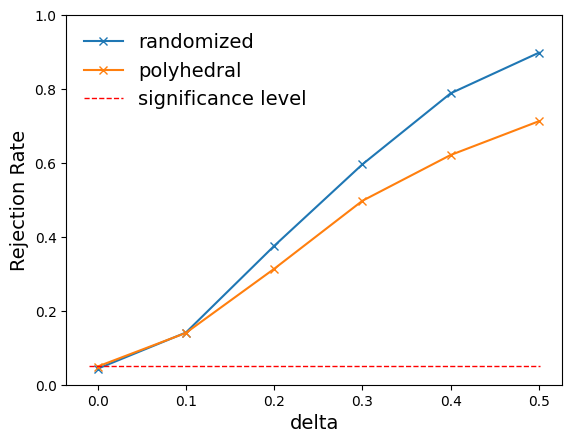

In [ ]:
signals = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.plot(signals, reject_rates["randomized"], label="randomized", marker="x")
plt.plot(signals, reject_rates["polyhedral"], label="polyhedral", marker="x")
plt.hlines(y=0.05, xmin=-0.01, xmax=0.501, colors="red", linestyles="dashed", linewidth=1, label="significance level")
plt.legend(frameon=False, fontsize=14)
plt.xlabel("delta", fontsize=14)
plt.ylabel("Rejection Rate", fontsize=14)
plt.ylim(0, 1)
plt.savefig("figure/reject_rate.pdf", bbox_inches="tight", pad_inches=0.0, transparent=True)
plt.show()


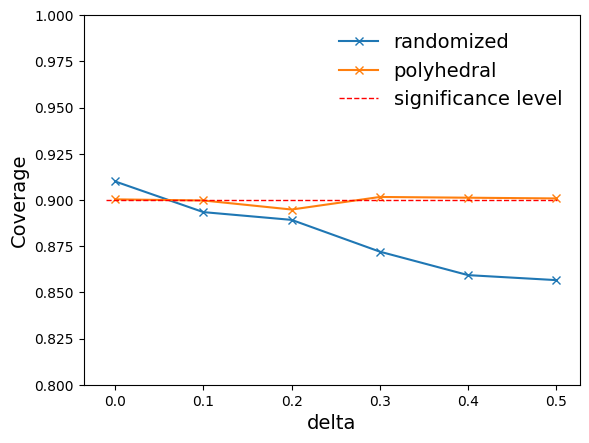

In [78]:
signals = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.plot(signals, coverages["randomized"], label="randomized", marker="x")
plt.plot(signals, coverages["polyhedral"], label="polyhedral", marker="x")
plt.hlines(y=0.9, xmin=-0.01, xmax=0.501, colors="red", linestyles="dashed", linewidth=1, label="significance level")
plt.legend(frameon=False, fontsize=14)
plt.xlabel("delta", fontsize=14)
plt.ylabel("Coverage", fontsize=14)
plt.ylim(0.8, 1.0)
plt.savefig("figure/coverage.pdf", bbox_inches="tight", pad_inches=0.0, transparent=True)
plt.show()


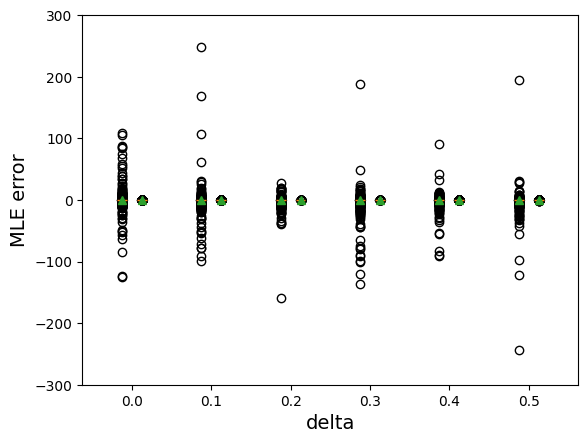

In [ ]:
num = 4
lim = 300
locs = np.arange(6 * num)

fig, ax = plt.subplots()
bplot = ax.boxplot(mle_errors["polyhedral"], positions=locs[::num], showmeans=True)
for flier in bplot['fliers']:
    flier.set_rasterized(True)
bplot = ax.boxplot(mle_errors["randomized"], positions=locs[1::num], showmeans=True)
for flier in bplot['fliers']:
    flier.set_rasterized(True)

plt.ylim(-lim, lim)
plt.xlim(-2, 6 * num - (num - 3))
plt.xticks(locs[::num] + 0.5, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel("delta", fontsize=14)
plt.ylabel("MLE error", fontsize=14)
plt.savefig(f"figure/mle_error_pm{lim}.pdf", bbox_inches="tight", pad_inches=0.0, transparent=True)
plt.show()

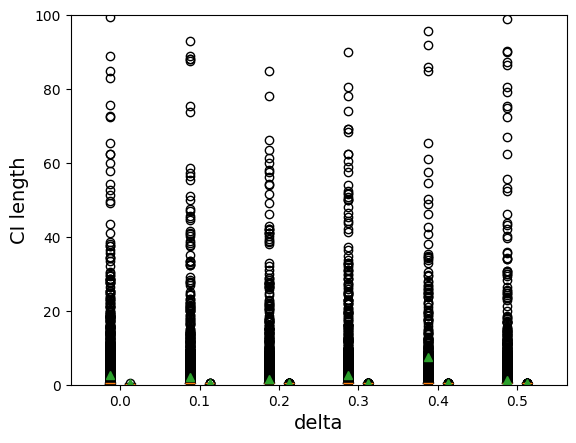

In [66]:
num = 4
lim = 100
locs = np.arange(6 * num)

fig, ax = plt.subplots()
bplot = ax.boxplot(ci_lengths["polyhedral"], positions=locs[::num], showmeans=True)
for flier in bplot['fliers']:
    flier.set_rasterized(True)
bplot = ax.boxplot(ci_lengths["randomized"], positions=locs[1::num], showmeans=True)
for flier in bplot['fliers']:
    flier.set_rasterized(True)

plt.ylim(0, lim)
plt.xlim(-2, 6 * num - (num - 3))
plt.xticks(locs[::num] + 0.5, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel("delta", fontsize=14)
plt.ylabel("CI length", fontsize=14)
plt.savefig(f"figure/ci_length_upto{lim}.pdf", bbox_inches="tight", pad_inches=0.0, transparent=True)
plt.show()